In [1]:
# Import librairies.
from src.utils import (  # local functions.
    extract_only_names, 
    select_first_element
)  
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import make_pipeline, make_union
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, validation_curve

# Modélisation

## Importation des données

In [2]:
# Load the movie data into a pandas DataFrame.
movies_df = pd.read_pickle("./data/movies_tmdb.pkl")
print("Initial dimension :", movies_df.shape)

# Conserver seulement les lignes avec des buget et revenue non nuls.
movies_df = movies_df.query('budget > 0 and revenue > 0')
print("Dimension after restriction:", movies_df.shape)

# Restrictions des colonnes.
columns = [
    "release_date", "budget", "genres", "popularity", 
    "production_companies", "production_countries", "runtime", 
    "vote_average", "vote_count", "revenue"
]
movies_df = movies_df[columns]

movies_df.head(1)

Initial dimension : (9999, 25)
Dimension after restriction: (4974, 25)


,release_date,budget,genres,popularity,production_companies,production_countries,runtime,vote_average,vote_count,revenue
0,2009-12-15,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",3086.55,"[{'id': 25, 'logo_path': '/qZCc1lty5FzX30aOCVR...","[{'iso_3166_1': 'US', 'name': 'United States o...",162,7.543,27045,2920357254


## Pré-traitement des données

### Traitements généraux

In [3]:
# Listes des colonnes à traiter. 
colnames = ["genres", "production_countries", "production_companies"]

# Appliquer les fonctions de néttoyage.
for colname in colnames:
    try:
        # Extraire uniquement les noms.
        movies_df[colname] = movies_df[colname].apply(extract_only_names)
        # Remplacer les listes vides par `numpy.nan`.
        movies_df[colname] = movies_df[colname].apply(lambda x: np.nan if not x else x)
    except:
        pass

movies_df[colnames].head(2)

,genres,production_countries,production_companies
0,"[Action, Adventure, Fantasy, Science Fiction]","[United States of America, United Kingdom]","[20th Century Fox, Ingenious Media, Dune Enter..."
3,"[Adventure, Family, Fantasy]","[United Kingdom, United States of America]","[Walt Disney Pictures, Walden Media, C.S. Lewi..."


In [4]:
# Missing values.
movies_df.isna().sum() 

release_date            0
budget                  0
genres                  1
popularity              0
production_companies    7
production_countries    3
runtime                 0
vote_average            0
vote_count              0
revenue                 0
dtype: int64

* Peu de valeurs manquantes par rapport à la taille initiale. Nous allons les supprimers ici.

In [5]:
# Supprimer les valeurs manquantesDelete missing values.
movies_df.dropna(inplace=True)

### Traitements spécifiques à la modélisation

#### **`genres`, `production_countries`, `production_companies`** 

1. **Extraction des attributs principaux.** : Au premier abord, nous allons considérer uniquement les attributs principaux pour les le genre, la production et les pays de chaque film, de sorte que nous extrayons le premier genre de la liste et l'utilisons comme caractéristique catégorielle. Nous utiliserons ensuite l'encodage à un coup ou l'encodage par étiquette pour représenter le genre primaire sous forme de valeur numérique dans la suite de la modélisation.

2. **Vectorisation suivi d'encodage**: Dans un second temps, nous pourrions tester la performance des modèles en utilisant les opérations de vectorisation sur ces variables catégorielles à modalité multiples. D'abord, on identifie la liste de tous les attributs unitaires qu'on ordonne. Un attribut unitaire est une modalité élémentaire. Le principe étant d'associer à chaque attribut unitaire une valeur entière. Ensuite, chaque modalité est représentée à l'aide d'un vecteur ordonnée dont la taille est le nombre d'attributs unitaires, et dont le k-ième élément indique la présence ou non de l'attribut numéro k. Par exemple, si on a :
|genres              |
|--------------------|
|["Action", "Family"]|
|["Adventure"]|

Les valeurs unitaires sont "Action", "Family" et "Adventure". Considérons l'ordre arbitraire (alphabétique): ("Action", "Adventure", "Family"). Alors la colonne `genres` sera représentée par:
|genres               |
|--------------------|
|(1, 0, 1)|
|(0, 1, 0)|

```python
#########################
##### Vectorisation #####
#########################

# Copier les donnees.
df = movies_df.copy()

# Identifier les valeurs unique dans la colonne genre. 
genres = df['genres'].apply(pd.Series).stack().unique()

# Créer une correspondance de genre à entier.
genre_map = {genre: i for i, genre in enumerate(genres)}

# Remplacer les genres par leur valeur entières.
df['genres'] = df['genres'].apply(lambda x: [genre_map[g] for g in x])

# Convertir la colonne genre en une matrix dense/
genres_matrix = pd.get_dummies(df['genres'].apply(pd.Series).stack()).groupby(level=0).apply(max)

# Ajouter la matrice au dataframe.
df = pd.concat([df, genres_matrix], axis=1)
```

In [6]:
###########################################
### Extraction des attributs principaux.###
###########################################

for colname in colnames:
    print(colname)
    movies_df[colname] = movies_df[colname].apply(select_first_element)
    
movies_df[colnames].head(5)

genres
production_countries
production_companies


,genres,production_countries,production_companies
0,Action,United States of America,20th Century Fox
3,Adventure,United Kingdom,Walt Disney Pictures
4,Family,Germany,Imagine Entertainment
6,Action,United States of America,DreamWorks Animation
7,Adventure,United Kingdom,Warner Bros. Pictures


#### **`Release date`** 

Nous avons réfléchi à plusieurs façons de gérer ces caractéristiques pour notre modélisation. Parmi celles-ci :

1. Utiliser les dates **tel quel**. Cela est intéressant car on conserverais toute l'information mais impliquerait trop de catégories à inclure et expliquerait la matrice des caractéristiques pour les modèles qui ont besoin d'un encodage catégoriel. 

2. **Regrouper les dates** dans des catégories, telles que "récent", "moyen" et "ancien", en fonction de la date de sortie, puis utiliser ces catégories comme une caractéristique catégorielle dans notre modèle. Nous ne souffrons plus du problème de cardinalité élevée. Néanmoins, il est clair, d'après l'analyse descriptive, que les recettes du box-office ont augmenté au fil des ans et que cette tendance se poursuit. 

3. **Extraire les caractéristiques de la date**: la troisième option consiste à extraire des caractéristiques de la colonne `release_date`, telles que l'année, le mois et le jour. On peut ensuite utiliser ces caractéristiques comme données d'entrée de le modèle d'apprentissage. Cela pourrait être intéressant si l'on pense que par exemple, le mois ou le jour de sortie a un impact. Cette dernière hypothèse paraît très peu plausible, encore moins à long-terme. 

- Finalement, nous avons décidé d'écarter cette variable dans le cas de notre étude. Nous pensons qu'elle pourrait être mieux exploitée par une analyse de série temporelle qui étudie des saisonnalités (cycle) de réussite, éventuellement désagrégé par pays de production (panel). 

In [7]:
# Supprimer la date de sortie.
movies_df.drop(columns=["release_date"], inplace=True)

#### Variables numériques à grande variabilités

Les films ont des chiffres d'affaires (`revenue`) et `budget` très élévé. Ainsi, afin de réduire l'influence des valeurs extrêmes et améliorer la linéarité du modèle (utile pour la régression linéaire surtout), nous utiliserons le logarithme. En effet, la fonction logarithme permet de réduire l'influence des valeurs extrêmes sur le modèle, car elle "étale" les valeurs sur une plage plus large. Cela peut être utile si vous avez des valeurs de chiffre d'affaires très élevées ou très faibles qui pourraient autrement perturber le modèle. D'autre part, si la relation entre les features et la cible n'est pas linéaire, utiliser la fonction log sur la cible peut aider à améliorer la linéarité et à rendre le modèle plus facile à interpréter. Enfin, quand on utilise log sur la cible, cela permet de facilement comparer les performances de notre modèle avec d'autres modèles en utilisant des métriques comme l'erreur absolue moyenne (MAE), ou le coefficient de détermination (R2).

In [8]:
# Calculer le logarithme du budget et du revenue.
movies_df["logbudget"] = np.log(movies_df["budget"]) 
movies_df["logrevenue"] = np.log(movies_df["revenue"])

#### **Variables catégorielles à cardinalité faible ou élevée**

La prochaine chose à laquelle nous devons faire attention, ce sont les variables catégorielles avec une **cardinalité faible ou élevée**. S'il n'y a qu'une seule catégorie dans une colonne, elle ne fournira aucune information unique à notre modèle. À l'autre extrême, les colonnes où presque chaque ligne a sa propre catégorie n'aideront pas notre modèle à identifier des tendances utiles dans les données.

Jetons un coup d'œil à la cardinalité de nos caractéristiques.

In [9]:
# Unique values.
movies_df.nunique()

budget                   599
genres                    18
popularity              4561
production_companies     945
production_countries      61
runtime                  151
vote_average            2334
vote_count              2768
revenue                 4701
logbudget                599
logrevenue              4701
dtype: int64

La variable `production_companies` a trop de valeurs uniques (944 sur 5000 observations). Cela peut augmenter la dimensionnalité des données et les rendre difficiles à modéliser. Nous allons regrouper les sociétés de production dans des classes basées sur le nombre de films qu'elles ont produits (**discrétisation**). Cela aura pour conséquence de réduire le nombre de valeurs uniques et faciliter la modélisation des données.

In [10]:
# Define a function.
def number_values_cumulative(self, column, quantile):
    return (self[column].value_counts(normalize=True).cumsum() < quantile).sum()
# Define a method inside the DataFrame class.
pd.DataFrame.number_values_cumulative = number_values_cumulative

movies_df.number_values_cumulative("production_companies", 0.50)

12

In [11]:
for col in ["production_companies", "production_countries"]:
    print(pd.DataFrame([
        (q, movies_df.number_values_cumulative(col, q)) for q in np.linspace(0.1, 1.0, num=10)
    ], columns=["quantile", f"No {col}"]))

   quantile  No production_companies
0       0.1                        1
1       0.2                        2
2       0.3                        4
3       0.4                        7
4       0.5                       12
5       0.6                       27
6       0.7                       66
7       0.8                      168
8       0.9                      448
9       1.0                      945
   quantile  No production_countries
0       0.1                        0
1       0.2                        0
2       0.3                        0
3       0.4                        0
4       0.5                        0
5       0.6                        0
6       0.7                        1
7       0.8                        3
8       0.9                        7
9       1.0                       61


**Remarques**
* Douze (12) compagnies se partagent la production de 50% des films de notre jeu de données.
* 90% des films de notre jeu de données ont été produit dans 7 pays.

In [12]:
# Compter le nombre de films produits par chaque compagnies.
counts = movies_df['production_companies'].value_counts()

# Conserver les 12 premières compagnies. 
top_12 = counts[:12]

# Créer une classification pour les autres compagnies.
labels = ["compagnies_g" + str(i) for i in range(1, 5)]
others = pd.cut(counts[12:], bins=4, labels=labels)

# Concatener les 12 premières compagnies avec les autres.
bins = pd.concat([top_12, others])

# Renommer les items en utilisant le nom des compagnies au lieu de l'effectif.
for id, (key, value) in enumerate(bins.items()):
    if id < 12:
        bins[key] = key

# Associer les compagnies de production à leur classe respectives.
movies_df["production_companies2"] = movies_df["production_companies"].map(bins)

In [13]:
# import mapper
with open('src/country_to_continent.pkl', 'rb') as f:
    country_to_continent = pickle.load(f)
country_to_continent

# Use the map method to replace the values in the column
movies_df["production_countries2"] = movies_df["production_countries"].map(country_to_continent)

In [14]:
movies_df.columns

Index(['budget', 'genres', 'popularity', 'production_companies',
       'production_countries', 'runtime', 'vote_average', 'vote_count',
       'revenue', 'logbudget', 'logrevenue', 'production_companies2',
       'production_countries2'],
      dtype='object')

## Partage du jeu en données d'apprentissage et données test. 

In [15]:
# Subset Data.
modelcols = [
    "logbudget", "logrevenue", "production_companies2", "production_countries2", "popularity", 
    "runtime", "vote_average", "vote_count", "genres"
]
movies2_df = movies_df[modelcols]

# Split features and target.
target="logrevenue"
X = movies2_df.drop(columns=target)
y = movies2_df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

# Train-Test split.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X shape: (4965, 8)
y shape: (4965,)
X_train shape: (3972, 8)
y_train shape: (3972,)
X_test shape: (993, 8)
y_test shape: (993,)


## Création de pipelines.

**Pipelines**
- [x] Dealing Missing values
- [x] Handling Outliers
- [x] One Hot Encoding (categorical features)
- [x] Normalization Operations (numerical features)
- [ ] ~Vectorization? (for features with list as values)~

In [16]:
# Filtrer les variables explicatives selon leur types.
numerical_features = make_column_selector(dtype_include=np.number)
categorical_features = make_column_selector(dtype_include=object)

# Créer une pipeline de transformation pour chaque type de colonne.
## Imputer les manquants par la médiane et standardiser les numériques. 
numerical_pipeline = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler()
)

## Imputer les manquants par le mode et one-hot les catégorielles.
categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'), 
    OneHotEncoder(drop=None, handle_unknown='ignore')
)

# Créer un tranformeur pour appliquer les pipelines à chaque groupe
preprocessor = make_column_transformer(
    (numerical_pipeline, numerical_features),
    (categorical_pipeline, categorical_features)
)

## Baseline (performance de référence)

* Le modèle de référence à battre pour savoir si on a vraiment bien fait plus tard.

In [17]:
# Baseline Model: Mean
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_r2 = r2_score(y_train, y_pred_baseline)
baseline_mse = mean_squared_error(y_train, y_pred_baseline)
print("Mean log-revenue:", round(y_mean, 2))
print("Baseline R2:", baseline_r2.round(2))
print("Baseline MSE:", baseline_mse.round(2))

Mean log-revenue: 17.19
Baseline R2: 0.0
Baseline MSE: 3.71


## Itération, réglage des hyperparamètres et évaluation des modèles

### Régression Linéaire

In [18]:
# Créer des pipelines
## Régression linéaire - MCO.
mco_pip = make_pipeline(
    preprocessor,
    LinearRegression(n_jobs=-1)
)        

## Lasso.
lasso_pip = make_pipeline(
    preprocessor,
    Lasso(random_state=42)
)  

## Ridge.
ridge_pip = make_pipeline(
    preprocessor,
    Ridge(random_state=42)
)  

# Ajuster le modèle aux données d'entraînement.
mco_pip.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd87685c90>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd87687250>)])),
                ('linearregression', LinearRegression(n_jobs=-1))])

In [19]:
# Perform cross-validation
models = {
    "MCO": mco_pip,
    "LASSO": lasso_pip,
    "RIDGE": ridge_pip
}

for name, model in models.items():
    score_mse = cross_val_score(model, X_train, y_train, cv=10, scoring="neg_mean_squared_error").mean()
    print(f"{name} MSE: {-score_mse.round(5)}")

MCO MSE: 1.88428
LASSO MSE: 3.2493
RIDGE MSE: 1.88342


* As excpected MCO perform better than lasso and ridge (by definition)

In [20]:
# hyperparameter tuning for LASSO and RIDGE with GridSearchCV()

# Communiquer les résultats

In [21]:
# Choose a model.
model = mco_pip

In [22]:
# Extraire la constante et les coefficients.
intercept = model.named_steps["linearregression"].intercept_
coefficients = model.named_steps["linearregression"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

# Extraire les noms des variables des données encodées à partir du OHE.
feature_names = model[:-1].get_feature_names_out()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

coefficients len: 45
[1.0162473  0.00734616 0.01655818 0.26217624 0.47579011]
features len: 45
['pipeline-1__logbudget' 'pipeline-1__popularity' 'pipeline-1__runtime'
 'pipeline-1__vote_average' 'pipeline-1__vote_count']


In [23]:
feat_imp = pd.Series(data=coefficients, index=feature_names)
feat_imp.head()

pipeline-1__logbudget       1.016247
pipeline-1__popularity      0.007346
pipeline-1__runtime         0.016558
pipeline-1__vote_average    0.262176
pipeline-1__vote_count      0.475790
dtype: float64

In [24]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 17.25
+ (1.02 * pipeline-1__logbudget)
+ (0.01 * pipeline-1__popularity)
+ (0.02 * pipeline-1__runtime)
+ (0.26 * pipeline-1__vote_average)
+ (0.48 * pipeline-1__vote_count)
+ (0.15 * pipeline-2__production_companies2_20th Century Fox)
+ (0.18 * pipeline-2__production_companies2_Columbia Pictures)
+ (0.09 * pipeline-2__production_companies2_DreamWorks Pictures)
+ (-0.11 * pipeline-2__production_companies2_Metro-Goldwyn-Mayer)
+ (-0.15 * pipeline-2__production_companies2_Miramax)
+ (0.16 * pipeline-2__production_companies2_New Line Cinema)
+ (0.23 * pipeline-2__production_companies2_Paramount)
+ (0.22 * pipeline-2__production_companies2_United Artists)
+ (0.15 * pipeline-2__production_companies2_Universal Pictures)
+ (-0.08 * pipeline-2__production_companies2_Village Roadshow Pictures)
+ (0.17 * pipeline-2__production_companies2_Walt Disney Pictures)
+ (-0.12 * pipeline-2__production_companies2_Warner Bros. Pictures)
+ (-0.53 * pipeline-2__production_companies2_compagnies_g1)
+ 

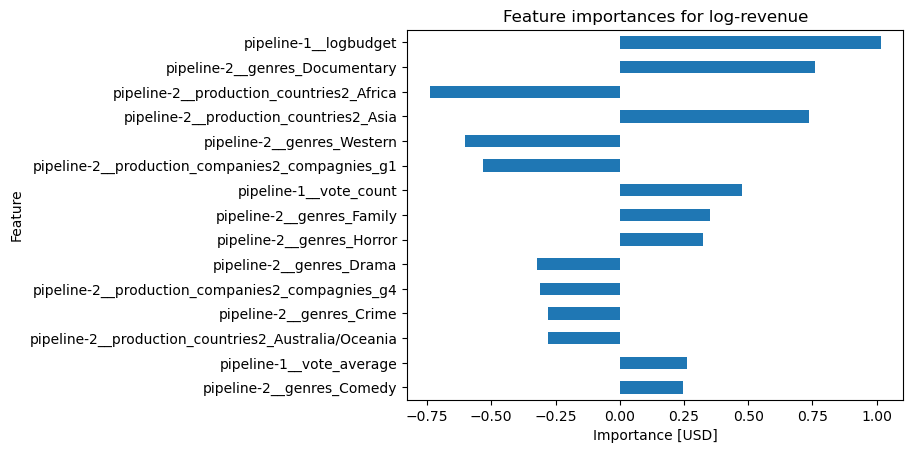

In [25]:
# select and plot
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature importances for log-revenue");

* Les variables qui contribuent le plus à la prédiction du revenue sont le budget, et le fait de produire un film en Afrique ou en Asie. Les films produits en Afrique rapportent en général beaucoup moins que la moyenne de l'ensemble des films du jeu de données. Cela s'expliquerait par le fait d'une plus faible audience, et de manière général des revenue individuels plus faibles. Un budget plus important semble être associé à des revenues d'autant plus grand. L'investissement a un effet positif en général. Par ailleurs, on retrouve les principales sociétés de production comme Paramount, Walt Disney et 20th Century Fox, qui produisent des films rapportant en moyenne 25% plus que la moyenne.